# generate-DE-test-figures-DDA
6.27.23

Here we're grabbing the post-imputation reconstructions from `DE-test-runner-Petralia2020.py`, conducting the DE tests and generating Precision Recall curves. 

Redoing this for the DDA dataset. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# import my modules
sys.path.append('../../../../bin/')
import util_functions
#import intermediate_plots

# plotting templates
sns.set(context="talk", style="ticks") 
sns.set_palette("tab10")

#### Configs

In [2]:
# for determining the ground truth DE peptides
    # also the imputed DE peptides
alpha = 0.01
correction = "BH"

# paths to the datasets. Starting from the trimmed datasets here because
#   we ended up removing a lot of peptides during the filtering step
cond1_path = "../data/Petralia2020-low-grad-glioma-quants.csv"
cond2_path = "../data/Petralia2020-ependymoma-quants.csv"

# original data filtering params
min_pres_orig = 16 # when selecting peptides to include in the DE 
                # analysis, what is the minimum number of present 
                # observations? 

#### Helper functions

In [3]:
def get_uncorrected_pvalues(mat1, mat2):
    """
    Get the raw (uncorrected) p-values evaluating the
    strength of the null hypothesis between every peptide
    for two experimental conditions
    
    Parameters
    ----------
    mat1, mat2 : np.ndarray, 
        The two quants matrices. Must be the same shape.
    Returns
    ----------
    pvals : np.array, 
        The p-values
    """
    pvals = []
    for i in range(0, mat1.shape[0]):
        res = stats.ttest_ind(mat1[i], mat2[i], nan_policy="omit")
        t_stat = res[0]
        p_val = res[1]
        pvals.append(p_val)

    pvals = np.array(pvals)
    return pvals

#### Perform the inital DE test
To get the ground truth DE peptides

In [4]:
# read in 
cond1_df = pd.read_csv(cond1_path)
cond2_df = pd.read_csv(cond2_path)

# get the list of peptide IDs
     # these will be the same for the two datasets
peptide_ids = np.array(cond1_df["PeptideSequence"])

# now remove the peptide ID columns
to_remove = ["PeptideSequence"]
cond1_df = cond1_df.drop(to_remove, axis=1)
cond2_df = cond2_df.drop(to_remove, axis=1)

# convert to numpy arrays
cond1_quants = np.array(cond1_df)
cond2_quants = np.array(cond2_df)

# subset down to just peptides with a low missinngess fraction
    # the missingness threshold is defined in the configs section
num_present_c1 = np.sum(~np.isnan(cond1_quants), axis=1)
discard = num_present_c1 < min_pres_orig

cond1_quants = np.delete(cond1_quants, discard, axis=0)
cond2_quants = np.delete(cond2_quants, discard, axis=0)
peptide_ids = np.delete(peptide_ids, discard, axis=0)

print("condition 1 quants: ", cond1_quants.shape)
print("condition 2 quants: ", cond2_quants.shape)

# get the ground truth DE peptides
    # what if I don't correct the p-values? 
gt_pvals = get_uncorrected_pvalues(cond1_quants, cond2_quants)    
reject_null_gt = np.float32(gt_pvals) < alpha
#DE_peptides_gt = list(peptide_ids[reject_null_gt])

# get the columns idx to split between experimental conditions
cols_cutoff = cond1_quants.shape[1]

condition 1 quants:  (26923, 23)
condition 2 quants:  (26923, 23)


***

## MNAR workflow

#### Read in the reconstructed dataframes

In [5]:
nmf_recon_mnar = pd.read_csv("../out/nmf-recon-mnar.csv")
knn_recon_mnar = pd.read_csv("../out/knn-recon-mnar.csv")
mf_recon_mnar = pd.read_csv("../out/missForest-recon-mnar.csv")
smin_recon_mnar = pd.read_csv("../out/sample-min-recon-mnar.csv")
gsample_recon_mnar = pd.read_csv("../out/gsample-recon-mnar.csv")
noimp_recon_mnar = pd.read_csv("../out/noimpute-recon-mnar.csv")

nmf_recon_mnar = np.array(nmf_recon_mnar)
knn_recon_mnar = np.array(knn_recon_mnar)
mf_recon_mnar = np.array(mf_recon_mnar)
smin_recon_mnar = np.array(smin_recon_mnar)
gsample_recon_mnar = np.array(gsample_recon_mnar)
noimp_recon_mnar = np.array(noimp_recon_mnar)

#### Separate the recon matrices into the two experimental conditions

In [6]:
# for the NMF model 
cond1_recon_nmf_mnar = nmf_recon_mnar[:,0:cols_cutoff]
cond2_recon_nmf_mnar = nmf_recon_mnar[:,cols_cutoff:]

# for the kNN model 
cond1_recon_knn_mnar = knn_recon_mnar[:,0:cols_cutoff]
cond2_recon_knn_mnar = knn_recon_mnar[:,cols_cutoff:]

# for missForest
cond1_recon_mf_mnar = mf_recon_mnar[:,0:cols_cutoff]
cond2_recon_mf_mnar = mf_recon_mnar[:,cols_cutoff:]

# for min impute
cond1_recon_smin_mnar = smin_recon_mnar[:,0:cols_cutoff]
cond2_recon_smin_mnar = smin_recon_mnar[:,cols_cutoff:]

# for random sample impute
cond1_recon_gsample_mnar = gsample_recon_mnar[:,0:cols_cutoff]
cond2_recon_gsample_mnar = gsample_recon_mnar[:,cols_cutoff:]

# for no impute
cond1_noimp_mnar = noimp_recon_mnar[:,0:cols_cutoff]
cond2_noimp_mnar = noimp_recon_mnar[:,cols_cutoff:]

#### Get the corrected p-values for each reconstruction

In [7]:
# again, not correcting the p-values here
pvals_nmf_mnar = \
    get_uncorrected_pvalues(cond1_recon_nmf_mnar, cond2_recon_nmf_mnar)
pvals_knn_mnar = \
    get_uncorrected_pvalues(cond1_recon_knn_mnar, cond2_recon_knn_mnar)
pvals_mf_mnar = \
    get_uncorrected_pvalues(cond1_recon_mf_mnar, cond2_recon_mf_mnar)
pvals_gsample_mnar = \
    get_uncorrected_pvalues(cond1_recon_gsample_mnar, cond2_recon_gsample_mnar)
pvals_smin_mnar = \
    get_uncorrected_pvalues(cond1_recon_smin_mnar, cond2_recon_smin_mnar)
pvals_noimp_mnar = \
    get_uncorrected_pvalues(cond1_noimp_mnar, cond2_noimp_mnar)

pvals_noimp_mnar[np.isnan(pvals_noimp_mnar)] = 1.0

/net/gs/vol3/software/modules-sw-python/3.7.7/jupyter/5.7.9/Linux/CentOS7/x86_64/ipykernel_launcher.py:23: UserWarning: Warning: converting a masked element to nan.


#### Get the ground truth DE labels

In [8]:
gt_labels = reject_null_gt.astype(float)

#### Get the DE probabilities for each model 

In [9]:
# get the DE probabilities, for each model 
prob_true_nmf_mnar = 1 - pvals_nmf_mnar
prob_true_knn_mnar = 1 - pvals_knn_mnar
prob_true_mf_mnar = 1 - pvals_mf_mnar
prob_true_smin_mnar = 1 - pvals_smin_mnar
prob_true_gsample_mnar = 1 - pvals_gsample_mnar
prob_true_noimp_mnar = 1 - pvals_noimp_mnar

#### Get the Precision Recall stats for each model 

In [10]:
# call the sklearn PR plotting function 
pr_nmf_mnar, recall_nmf_mnar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_nmf_mnar)
pr_knn_mnar, recall_knn_mnar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_knn_mnar)
pr_mf_mnar, recall_mf_mnar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_mf_mnar)
pr_smin_mnar, recall_smin_mnar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_smin_mnar)
pr_gsample_mnar, recall_gsample_mnar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_gsample_mnar)
pr_noimp_mnar, recall_noimp_mnar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_noimp_mnar)

#### Get the AUCs

In [11]:
# get the AUCs
nmf_auc_mnar = np.around(auc(recall_nmf_mnar, pr_nmf_mnar), 2)
knn_auc_mnar = np.around(auc(recall_knn_mnar, pr_knn_mnar), 2)
mf_auc_mnar = np.around(auc(recall_mf_mnar, pr_mf_mnar), 2)
smin_auc_mnar = np.around(auc(recall_smin_mnar, pr_smin_mnar), 2)
gsample_auc_mnar = np.around(auc(recall_gsample_mnar, pr_gsample_mnar), 2)
noimp_auc_mnar = np.around(auc(recall_noimp_mnar, pr_noimp_mnar), 2)

#### Plot!

Text(0.5, 1.0, 'MNAR')

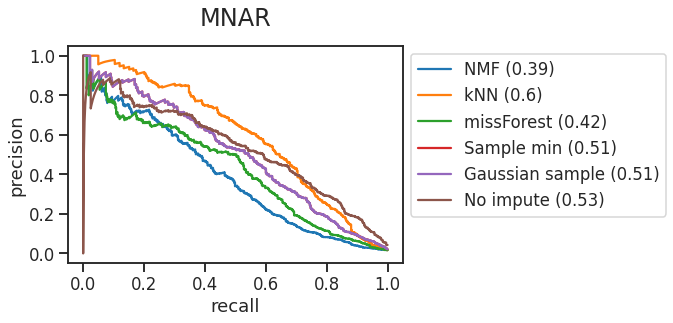

In [12]:
plt.figure()

plt.plot(
    recall_nmf_mnar, pr_nmf_mnar, 
    label="NMF (" + str(nmf_auc_mnar) + ")")
plt.plot(
    recall_knn_mnar, pr_knn_mnar, 
    label="kNN (" + str(knn_auc_mnar) + ")")
plt.plot(
    recall_mf_mnar, pr_mf_mnar, 
    label="missForest (" + str(mf_auc_mnar) + ")")
plt.plot(
    recall_smin_mnar, pr_smin_mnar, 
    label="Sample min (" + str(smin_auc_mnar) + ")")
plt.plot(
    recall_gsample_mnar, pr_gsample_mnar, 
    label="Gaussian sample (" + str(gsample_auc_mnar) + ")")
plt.plot(
    recall_noimp_mnar, pr_noimp_mnar, 
    label="No impute (" + str(noimp_auc_mnar) + ")")

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("MNAR", pad=20, size=24)

# plt.savefig(
#     "logs/DE-experiment-MNAR.png", dpi=250, bbox_inches="tight"
# )

***

## MCAR workflow

#### Read in the reconstructed matrices

In [13]:
nmf_recon_mcar = pd.read_csv("../out/nmf-recon-mcar.csv")
knn_recon_mcar = pd.read_csv("../out/knn-recon-mcar.csv")
mf_recon_mcar = pd.read_csv("../out/missForest-recon-mcar.csv")
sample_min_recon_mcar = pd.read_csv("../out/sample-min-recon-mcar.csv")
gsample_recon_mcar = pd.read_csv("../out/gsample-recon-mcar.csv")
noimp_recon_mcar = pd.read_csv("../out/noimpute-recon-mcar.csv")

nmf_recon_mcar = np.array(nmf_recon_mcar)
knn_recon_mcar = np.array(knn_recon_mcar)
mf_recon_mcar = np.array(mf_recon_mcar)
sample_min_recon_mcar = np.array(sample_min_recon_mcar)
gsample_recon_mcar = np.array(gsample_recon_mcar)
noimp_recon_mcar = np.array(noimp_recon_mcar)

#### Separate into the two experimental conditions

In [14]:
# for the NMF model 
cond1_recon_nmf_mcar = nmf_recon_mcar[:,0:cols_cutoff]
cond2_recon_nmf_mcar = nmf_recon_mcar[:,cols_cutoff:]

# for the kNN model 
cond1_recon_knn_mcar = knn_recon_mcar[:,0:cols_cutoff]
cond2_recon_knn_mcar = knn_recon_mcar[:,cols_cutoff:]

# for missForest
cond1_recon_mf_mcar = mf_recon_mcar[:,0:cols_cutoff]
cond2_recon_mf_mcar = mf_recon_mcar[:,cols_cutoff:]

# for min impute
cond1_recon_smin_mcar = sample_min_recon_mcar[:,0:cols_cutoff]
cond2_recon_smin_mcar = sample_min_recon_mcar[:,cols_cutoff:]

# for random sample impute
cond1_recon_gsample_mcar = gsample_recon_mcar[:,0:cols_cutoff]
cond2_recon_gsample_mcar = gsample_recon_mcar[:,cols_cutoff:]

# for no impute
cond1_noimp_mcar = noimp_recon_mcar[:,0:cols_cutoff]
cond2_noimp_mcar = noimp_recon_mcar[:,cols_cutoff:]

#### Get the corrected p-values for each reconstruction

In [15]:
# again, not correcting the p-values here
pvals_nmf = \
    get_uncorrected_pvalues(cond1_recon_nmf_mcar, cond2_recon_nmf_mcar)
pvals_knn = \
    get_uncorrected_pvalues(cond1_recon_knn_mcar, cond2_recon_knn_mcar)
pvals_mf = \
    get_uncorrected_pvalues(cond1_recon_mf_mcar, cond2_recon_mf_mcar)
pvals_gsample = \
    get_uncorrected_pvalues(cond1_recon_gsample_mcar, cond2_recon_gsample_mcar)
pvals_smin = \
    get_uncorrected_pvalues(cond1_recon_smin_mcar, cond2_recon_smin_mcar)
pvals_noimp = \
    get_uncorrected_pvalues(cond1_noimp_mcar, cond2_noimp_mcar)

pvals_noimp[np.isnan(pvals_noimp)] = 1.0

/net/noble/vol2/home/lincolnh/.local/lib/python3.7/site-packages/scipy/stats/mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
/net/gs/vol3/software/modules-sw-python/3.7.7/jupyter/5.7.9/Linux/CentOS7/x86_64/ipykernel_launcher.py:23: UserWarning: Warning: converting a masked element to nan.


#### Get the DE probabilities for each impute method

In [16]:
prob_true_nmf_mcar = 1 - pvals_nmf
prob_true_knn_mcar = 1 - pvals_knn
prob_true_mf_mcar = 1 - pvals_mf
prob_true_smin_mcar = 1 - pvals_smin
prob_true_gsample_mcar = 1 - pvals_gsample
prob_true_noimp_mcar = 1 - pvals_noimp

#### Get the Precision Recall stats for each method

In [17]:
# call the sklearn PR plotting function 
pr_nmf_mcar, recall_nmf_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_nmf_mcar)
pr_knn_mcar, recall_knn_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_knn_mcar)
pr_mf_mcar, recall_mf_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_mf_mcar)
pr_smin_mcar, recall_smin_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_smin_mcar)
pr_gsample_mcar, recall_gsample_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_gsample_mcar)
pr_noimp_mcar, recall_noimp_mcar, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_noimp_mcar)

#### Get the AUCs

In [18]:
nmf_auc_mcar = np.around(auc(recall_nmf_mcar, pr_nmf_mcar), 2)
knn_auc_mcar = np.around(auc(recall_knn_mcar, pr_knn_mcar), 2)
mf_auc_mcar = np.around(auc(recall_mf_mcar, pr_mf_mcar), 2)
smin_auc_mcar = np.around(auc(recall_smin_mcar, pr_smin_mcar), 2)
gsample_auc_mcar = np.around(auc(recall_gsample_mcar, pr_gsample_mcar), 2)
noimp_auc_mcar = np.around(auc(recall_noimp_mcar, pr_noimp_mcar), 2)

#### Plot

Text(0.5, 1.0, 'MCAR')

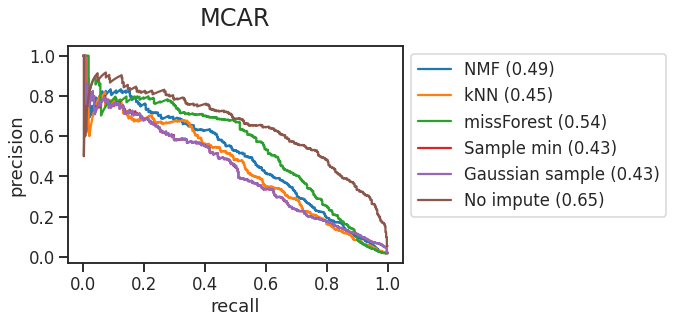

In [19]:
plt.figure()

plt.plot(
    recall_nmf_mcar, pr_nmf_mcar, 
    label="NMF (" + str(nmf_auc_mcar) + ")")
plt.plot(
    recall_knn_mcar, pr_knn_mcar, 
    label="kNN (" + str(knn_auc_mcar) + ")")
plt.plot(
    recall_mf_mcar, pr_mf_mcar, 
    label="missForest (" + str(mf_auc_mcar) + ")")
plt.plot(
    recall_smin_mcar, pr_smin_mcar, 
    label="Sample min (" + str(smin_auc_mcar) + ")")
plt.plot(
    recall_gsample_mcar, pr_gsample_mcar, 
    label="Gaussian sample (" + str(gsample_auc_mcar) + ")")
plt.plot(
    recall_noimp_mcar, pr_noimp_mcar, 
    label="No impute (" + str(noimp_auc_mcar) + ")")

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("MCAR", pad=20, size=24)

# plt.savefig(
#     "logs/DE-experiment-MCAR.png", dpi=250, bbox_inches="tight"
# )

***

## Plot MNAR and MCAR side-by-side

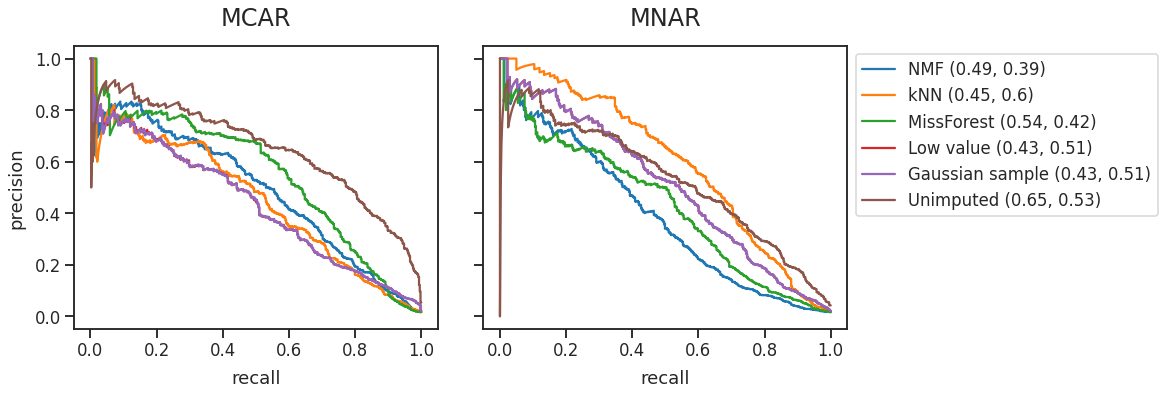

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5), sharey=True, sharex=True) 
fig.tight_layout()

# The MCAR plot
axes[0].plot(
    recall_nmf_mcar, pr_nmf_mcar)
axes[0].plot(
  recall_knn_mcar, pr_knn_mcar)
axes[0].plot(
    recall_mf_mcar, pr_mf_mcar)
axes[0].plot(
    recall_smin_mcar, pr_smin_mcar)
axes[0].plot(
    recall_gsample_mcar, pr_gsample_mcar)
axes[0].plot(
    recall_noimp_mcar, pr_noimp_mcar)
axes[0].set_xlabel("recall", labelpad=10)
axes[0].set_ylabel("precision", labelpad=10)
axes[0].set_title("MCAR", pad=20, size=24)

# The MNAR plot
axes[1].plot(
    recall_nmf_mnar, pr_nmf_mnar, 
    label="NMF (" + str(nmf_auc_mcar) + ", " + str(nmf_auc_mnar) + ")")
axes[1].plot(
    recall_knn_mnar, pr_knn_mnar, 
    label="kNN (" + str(knn_auc_mcar) + ", " + str(knn_auc_mnar) + ")")
axes[1].plot(
    recall_mf_mnar, pr_mf_mnar, 
    label="MissForest (" + str(mf_auc_mcar) + ", " + str(mf_auc_mnar) + ")")
axes[1].plot(
    recall_smin_mnar, pr_smin_mnar, 
    label="Low value ("+ str(smin_auc_mcar) + ", " + str(smin_auc_mnar) + ")")
axes[1].plot(
    recall_gsample_mnar, pr_gsample_mnar, 
    label="Gaussian sample ("+ str(gsample_auc_mcar) + ", " + str(gsample_auc_mnar) + ")")
axes[1].plot(
    recall_noimp_mnar, pr_noimp_mnar, 
    label="Unimputed ("+ str(noimp_auc_mcar) + ", " + str(noimp_auc_mnar) + ")")
axes[1].set_xlabel("recall", labelpad=10)
axes[1].set_ylabel("")
axes[1].set_title("MNAR", pad=20, size=24)
axes[1].legend(bbox_to_anchor=(1,1))

plt.savefig(
    "../out/DE-experiment-multipanel-DDA-v1.png", dpi=250, bbox_inches="tight"
)